#Importing Necessary Libararies

In [2]:
import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Data Visualisation

Biggest image in the dataset is of dimension:(765, 500, 3)
Smallest image in the dataset is of dimension:(241, 500, 3)


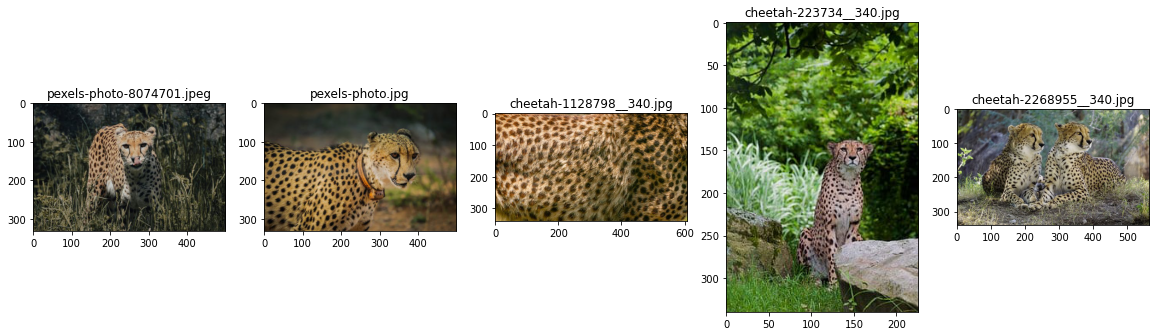

In [6]:
#A list to store the dimensions of each image of the dataset.
image_dims = []
#Path to the dataset
img_folder = '../data/BigCats'                               
animals = ['/Leopard', '/Cheetah', '/Jaguar', '/Lion', '/Tiger']
choice_animals = int(input('What animal picture samples would you like to visualise?\nEnter   0 - Leopard\n \t1 - Cheetah\n \t2 - Jaguar\n \t3 - Lion\n \t4 - Tiger\n \t5 - One sample for each of the above\n'))

plt.figure(figsize=(20,20))

for i in range(5):
    if choice_animals == 0:
        file = random.choice(os.listdir(img_folder + animals[0]))
        image_path = os.path.join(img_folder + animals[0], file)
    if choice_animals == 1:
        file = random.choice(os.listdir(img_folder + animals[1]))
        image_path = os.path.join(img_folder + animals[1], file)
    if choice_animals == 2:
        file = random.choice(os.listdir(img_folder + animals[2]))
        image_path = os.path.join(img_folder + animals[2], file)
    if choice_animals == 3:
        file = random.choice(os.listdir(img_folder + animals[3]))
        image_path = os.path.join(img_folder + animals[3], file)
    if choice_animals == 4:
        file = random.choice(os.listdir(img_folder + animals[4]))
        image_path = os.path.join(img_folder + animals[4], file)
    if choice_animals == 5:
        file = random.choice(os.listdir(img_folder + animals[i]))
        image_path = os.path.join(img_folder + animals[i], file)
    img = mpimg.imread(image_path)
    ax=plt.subplot(1, 5, i+1)
    ax.title.set_text(file)
    plt.imshow(img)         #Plottiing sample images


for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):       
        image_path = os.path.join(img_folder, dir1, file)
        image_dims.append(cv2.imread(image_path).shape)

max_dim = max(image_dims)   #Finding the largest dimension from all the image dimensions
min_dim = min(image_dims)   #Finding the smallest dimension from all the image dimensions
print('Biggest image in the dataset is of dimension:' + str(max_dim))
print('Smallest image in the dataset is of dimension:' + str(min_dim))

#Data Transformation

In [3]:
data_choice = int(input('Which method would you like to use on the data?\n\t0 - Nothing\n\t1 - SIFT\n\t2 - MDS\n'))
IMG_HEIGHT = 400    #Declaring the dimensions of the images to be resized.
IMG_WIDTH = 500

#Creation of SIFT function if the user opts to use SIFT
if data_choice == 1:
  sift = cv2.SIFT_create(8)

#Creating a dataset by importing all the images and their class labels, and converting the images to a numeric array.
def create_dataset(img_folder):
    img_data_array = []
    class_name = []
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path = os.path.join(img_folder, dir1,  file)
            if data_choice == 0 or data_choice == 2:
              image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_NEAREST)     #Resizing the image
              image = np.array(image)                                                                   #Coverting the image to an array
              image = image.astype('float32')
              image /= 255                                                                              #Scaling the Values by dividing array with channel value range
            elif data_choice == 1:
              image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)
              image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_NEAREST)     #Resizing the image
              kp, des = sift.detectAndCompute(image, None)                                              #SIFT function computes the key points and descriptors                                                           
              #Making a key point array
              image_temp = []
              for i in range(8):
                image_temp.append([kp[i].pt[0], kp[i].pt[1]])
              image = image_temp

            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

img_data, class_name = create_dataset('../data/BigCats')

#Feature extraction, Dimension reduction and no modification:
if data_choice == 0:
  img_data = np.array(img_data, np.float32).reshape(170, 600000)                #Reshaping array dimensions
elif data_choice == 1:
  img_data = np.array(img_data, np.float32).reshape(170, 16)                    #Reshaping array dimensions
elif data_choice == 2:
  img_data = np.array(img_data, np.float32).reshape(170, 600000)                #Reshaping array dimensions
  dm = distance_matrix(img_data, img_data)                                      #Calculating the dissimilarity matrix
  mds = MDS(n_components=2, random_state=42)                                    #Creating MDS model
  img_data = mds.fit_transform(dm)                                              #Scaling the image data to 2 dimensions

#Encoding class labels
le = preprocessing.LabelEncoder()
cats_encoded = le.fit_transform(class_name)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


In [6]:
classification_choice = int(input('Which classification model would you like to use?\n\t0 - Random Forest\n\t1 - SVM \n\t2 - K Nearest Neighbours\n'))

#Splitting Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(img_data, cats_encoded, test_size=0.2, random_state=42)

if classification_choice == 0:
  rfc = RandomForestClassifier(n_estimators = 16, max_depth = 8, criterion = "gini", random_state = 42)                 #Random Forest (RF) model creation
  rfc.fit(X_train, y_train)                                                                                             #Training RF model
  y_pred = rfc.predict(X_test)                                                                                          #Testing RF model
  print('Accuracy of the Random Forest model was ' + str(accuracy_score(y_test, y_pred)*100))

elif classification_choice == 1:
  SVM = svm.SVC()                                                                                                       #Support Vector Machines (SVM) model creation
  SVM.fit(X_train, y_train)                                                                                             #Training SVM model
  y_pred = SVM.predict(X_test)                                                                                          #Testing SVM model
  print('Accuracy of the SVM model was ' + str(accuracy_score(y_test, y_pred)*100))

elif classification_choice == 2:
  k_nn = KNeighborsClassifier(n_neighbors=31, weights='distance', p = 2, algorithm='auto')                              #K Nearest Neighbours (KNN) model creation
  k_nn.fit(X_train, y_train)                                                                                            #Training KNN model
  y_pred = k_nn.predict(X_test)                                                                                         #Testing KNN model
  print('Accuracy of the K Nearest Neighbours model was ' + str(accuracy_score(y_test, y_pred)*100) + '% when K = 9')

Accuracy of the K Nearest Neighbours model was 26.47058823529412% when K = 9


#Leave One Out Cross Validation

In [11]:
loo = LeaveOneOut()                 #Leave-One-Out cross-validator
loo.get_n_splits(img_data)
acc = 0

if classification_choice == 0:
  for train_index, test_index in loo.split(img_data):
      X_train, X_test = img_data[train_index], img_data[test_index]                                                   #Train and Test split for image data
      y_train, y_test = cats_encoded[train_index], cats_encoded[test_index]                                           #Train and Test split for class labels
      loov_model = RandomForestClassifier(n_estimators = 16, max_depth = 8, criterion = "gini", random_state = 42)    #RF model creation
      loov = loov_model.fit(X_train, y_train)                                                                         #Training RF model
      if loov.predict(X_test) == y_test:                                                                              #Testing the prediction against the actual value
        acc += 1
  print('Average accuracy of the Random Forest model in Leave One Out Crossvalidation: ' + str(acc/170))

elif classification_choice == 1:
  for train_index, test_index in loo.split(img_data):
      X_train, X_test = img_data[train_index], img_data[test_index]                                                   #Train and Test split for image data
      y_train, y_test = cats_encoded[train_index], cats_encoded[test_index]                                           #Train and Test split for class labels
      loov_model = svm.SVC()                                                                                          #SVM model creation
      loov = loov_model.fit(X_train, y_train)                                                                         #Training SVM model
      if loov.predict(X_test) == y_test:                                                                              #Testing the prediction against the actual value
        acc += 1
  print('Average accuracy of the SVM model in Leave One Out Crossvalidation: ' + str(acc/170))

elif classification_choice == 2:
  for train_index, test_index in loo.split(img_data):
      X_train, X_test = img_data[train_index], img_data[test_index]                                                   #Train and Test split for image data
      y_train, y_test = cats_encoded[train_index], cats_encoded[test_index]                                           #Train and Test split for class labels
      loov_model = KNeighborsClassifier(n_neighbors = 31, weights = 'distance', p = 2, algorithm = 'auto')                                                              #KNN model creation
      loov = loov_model.fit(X_train, y_train)                                                                         #Training KNN model
      if loov.predict(X_test) == y_test:                                                                              #Testing the prediction against the actual value
        acc += 1
  print('Average accuracy of the K Nearest Neighboours model in Leave One Out Crossvalidation: ' + str(acc/170))

Average accuracy of the SVM model in Leave One Out Crossvalidation: 0.40588235294117647


#Clustering

In [12]:
  #Splitting Data for Training and Testing
  X_train, X_test, y_train, y_test = train_test_split(img_data, cats_encoded, test_size=0.2, random_state=42)
  kmeans = KMeans(n_clusters = 3)                  #K-Means model creation
  X = metrics.pairwise_distances(X_test)           #Pairwise distance computation
  y_pred = kmeans.fit_predict(X)                   #Prediction of class labels
  SC = metrics.silhouette_score(X, y_pred)         #Computation of Silhouette score
  print('Silhouette score for the K Means model: ' + str(SC))

Silhouette score for the K Means model: 0.24367866
